# 1.DataSet Processing

In [1]:
!pip install nltk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import json
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd
import torch
import torch.nn as nn
import re
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence

nltk.download('punkt')
nltk.download('stopwords')

def load_data(filePath):
    with open(filePath, 'r') as file:
        data = json.load(file)
    return data

def tokenize(text):
    text_lowercase = text.lower()
    text_lowercase = re.sub(r'[^\w\s]', '', text_lowercase)
    tokenize_text = word_tokenize(text_lowercase)
    # stop_words = set(stopwords.words('english'))
    # tokens_without_stopwords = [token for token in tokenize_text if token not in stop_words]
    return tokenize_text

def create_vocabulary(claim_tokenized,evidence_tokenized):
    vocabulary = {'<pad>': 0, 'UNKNOWN_WORD':1}
    for tokenized_claims in claim_tokenized.values():
        for token in tokenized_claims:
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary)

    for tokenized_evidence in evidence_tokenized.values():
        for token in tokenized_evidence:
            if token not in vocabulary:
                vocabulary[token] = len(vocabulary)
    return vocabulary

def preprocess_data(train_claims_data,evidence_data):

    claim_tokenized = {}
    evidence_tokenized = {}

    print("Convert the claim training text into tokens...")
    for claim_id, claim in train_claims_data.items():
      tokenize_claim_text = tokenize(claim['claim_text'])
      claim_tokenized[claim_id] = tokenize_claim_text

    print("Convert the evidence training text into tokens...")
    for evidence_id, evidence in evidence_data.items():
      tokenize_evidence_text = tokenize(evidence)
      evidence_tokenized[evidence_id]  = tokenize_evidence_text

    print("Create vocabulary")
    vocabulary = create_vocabulary(claim_tokenized,evidence_tokenized)

    #Convert claim and evidence text to indices list
    print("Convert the claim and evidence to indices.")
    claim_as_indices = [[vocabulary[token] for token in claim_text] for claim_text in claim_tokenized.values()]
    evidence_as_indices = [[vocabulary[token] for token in evidence_text] for evidence_text in evidence_tokenized.values()]

    #Converting the claim indices to tensor
    print("Convert the claim text to tensor...")
    claim_as_tensors = [torch.tensor(sentence, dtype=torch.long) for sentence in claim_as_indices]

    #Padding the tensors
    print("Add padding to the claim text...")
    claims_padded = pad_sequence(claim_as_tensors, batch_first=True, padding_value=0)

    return claim_tokenized,evidence_tokenized,vocabulary,evidence_as_indices,claims_padded

print("Load the training data...")
data_path = "/content/drive/MyDrive/nlp_project/data"
train_claims_data = load_data(data_path+'/train-claims.json')
evidence_data = load_data(data_path+'/evidence.json')

print("Preprocessing started....")
claim_tokenized,evidence_tokenized,vocabulary,evidence_as_indices,claims_padded = preprocess_data(train_claims_data,evidence_data)
print("Preprocessing done!!!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Load the training data...
Preprocessing started....
Convert the claim training text into tokens...
Convert the evidence training text into tokens...
Create vocabulary
Convert the claim and evidence to indices.
Convert the claim text to tensor...
Add padding to the claim text...
Preprocessing done!!!


In [4]:
print("Create claim id and index relation...")
claim_id_index = {claim_id:index for index, claim_id in enumerate(train_claims_data)}
print("Create evidence id and index relation...")
evidence_id_index = {evidence_id:index for index, evidence_id in enumerate(evidence_data)}

max_len_evidence = max(len(evidence) for evidence in evidence_as_indices)
max_padding_length_train_claims = len(claims_padded[0])

Create claim id and index relation...
Create evidence id and index relation...


In [5]:
def remove_stop_words_from_data(tokenize_text):
  stop_words = set(stopwords.words('english'))
  tokens_without_stopwords = []
  for sentence in tokenize_text:
    tokens = [token for token in sentence if token not in stop_words]
    tokens_without_stopwords.append(tokens)
  return tokens_without_stopwords

In [6]:
def get_key_from_value(dict,target_value):
  for key, value in dict.items():
    if value == target_value:
      return key

In [7]:
def getPaddedEvidence(evidence_list):
    evidence_as_tensors = [torch.tensor(sentence, dtype=torch.long) for sentence in evidence_list]
    evidence_padded = pad_sequence(evidence_as_tensors, batch_first=True, padding_value=0)
    if evidence_padded.size(1) < max_len_evidence:
      additional_padding = max_len_evidence - evidence_padded.size(1)
      padding_tensor = torch.zeros((evidence_padded.size(0), additional_padding), dtype=evidence_padded.dtype)
      final_evidence_padded = torch.cat((evidence_padded, padding_tensor), dim=1)
    return final_evidence_padded

In [8]:
def get_evidence_from_claim_id(claim_id):
    evidences = train_claims_data[claim_id]["evidences"]
    evidence_index = [evidence_id_index[evidence] for evidence in evidences]
    selected_evidences = [evidence_as_indices[indices] for indices in evidence_index]
    evidence_padded = getPaddedEvidence(selected_evidences)
    return evidence_padded

Latent Semantic Analysis

In [9]:
from nltk.corpus import stopwords
import spacy

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def remove_stop_words_lemmatize(texts,batch_size=2000):
  processed_text = []
  for document in nlp.pipe(texts,batch_size=batch_size):
    final_tokens = [token.lemma_ for token in document if token.is_alpha and token.lemma_ not in stop_words]
    processed_text.append(' '.join(final_tokens))
  return processed_text

#Create tf-idf vector for evidence and claims dataset
text_evidence = list(evidence_data.values())
text_claim = [claim['claim_text'] for claim_id, claim in train_claims_data.items()]

sentence_corpus = text_evidence + text_claim
remove_stop_words_lemmatize_corpus = remove_stop_words_lemmatize(sentence_corpus)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
tfidf_vectorizer = TfidfVectorizer(stop_words = 'english',max_features=60000)
tfidf_evidence_claim_matrix = tfidf_vectorizer.fit_transform(remove_stop_words_lemmatize_corpus)
print(tfidf_evidence_claim_matrix.shape)

(1210055, 60000)


In [11]:
#Apply singular decompositon to matrix
n_components = 100
latent_semantic_model = TruncatedSVD(n_components=n_components)
latent_semantic_model_matrix = latent_semantic_model.fit_transform(tfidf_evidence_claim_matrix)

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
#Function to get top evidences based on a claim
def getTopKEvidences(tfidf_evidence_claim_matrix,latent_semantic_model_matrix,claim_text,evidences,k=5):
  vector_claim = tfidf_vectorizer.transform([claim_text])
  vector_claim = latent_semantic_model.transform(vector_claim)[0]
  vector_evidence = latent_semantic_model_matrix[:len(evidences)]

  #Using cosine similarity to calculate the similarities
  similarities = cosine_similarity([vector_claim], vector_evidence)[0]

  #Get top k evidences
  top_k_indices = similarities.argsort()[-k:][::-1]
  top_k_indices = top_k_indices.copy()
  selected_evidences = [evidence_as_indices[indices] for indices in top_k_indices]
  top_k_evidences_padded = getPaddedEvidence(selected_evidences)

  return top_k_evidences_padded, top_k_indices



# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

LSTM with word level attention

In [13]:
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import os
import matplotlib.pyplot as plt

class WordLevelClaimEvidenceAttention(nn.Module):
    def __init__(self,vocabulary_size,embedding_dimension,hidden_dimension,num_of_layers,dropout):
        super(WordLevelClaimEvidenceAttention, self).__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dimension)
        self.claim_lstm = nn.LSTM(embedding_dimension, hidden_dimension, num_of_layers, dropout=dropout, batch_first=True)
        self.evidence_lstm = nn.LSTM(embedding_dimension, hidden_dimension, num_of_layers, dropout=dropout, batch_first=True)
        self.attention_ffnn = nn.Linear(hidden_dimension, 1)
        self.final_lstm = nn.LSTM(hidden_dimension * 2, hidden_dimension, num_of_layers, dropout=dropout, batch_first=True)
        self.ffnn = nn.Linear(hidden_dimension, 4)

    def forward(self, claims, evidence):

        # Getting the Embeddings
        claims_embedded = self.embedding(claims).to(device)
        evidence_embedded = self.embedding(evidence).to(device)
        # Output for claims and evidence embeddings using LSTM
        lstm_claims_output, _ = self.claim_lstm(claims_embedded)
        lstm_evidence_output, _ = self.evidence_lstm(evidence_embedded)
        lstm_claims_output_reshape = lstm_claims_output.expand(lstm_evidence_output.size(0),-1,-1)

        # Attention mechanism to get attention_score
        attention_score = torch.bmm(lstm_claims_output_reshape, lstm_evidence_output.transpose(1, 2))
        # Applying softmax on attention_scores to get normalized attention weights
        attention_weights = functional.softmax(attention_score, dim=-1)

        # Calculating context vectors as a weighted sum of evidence vectors
        context_vectors = torch.bmm(attention_weights, lstm_evidence_output)
        # Aggregation of context vectors done on basis of attention
        context_vectors_attention_scores = self.attention_ffnn(context_vectors).squeeze(-1)
        context_vectors_attention_weights_agg = functional.softmax(context_vectors_attention_scores, dim=0)
        context_vector_attention_aggregated = torch.sum(context_vectors_attention_weights_agg.unsqueeze(-1) * context_vectors, dim=0)
        # Concatenated with claim
        concatenated_represenatation = torch.cat((lstm_claims_output.squeeze(0), context_vector_attention_aggregated), dim=-1)

        # Classification using the final representation using claim and evidence
        final_output_lstm, (hidden_state, cell_state) = self.final_lstm(concatenated_represenatation.unsqueeze(0))
        final_representation = hidden_state[-1]
        output_logits = self.ffnn(final_representation)
        return output_logits, attention_weights

In [14]:
def model_train(model, train_claims_data, claims_padded, epochs=10, learning_rate=0.0005):
    cross_entropy_loss_function = nn.CrossEntropyLoss()
    adam_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_training = []
    accuracy_training = []

    for epoch in range(epochs):
        count=0
        corr=0
        model.train()
        overall_loss = 0
        for claim_id in train_claims_data:
            claim_index = claim_id_index[claim_id]
            claim_tensor_padded = claims_padded[claim_index].unsqueeze(0).to(device)
            evidence_list = get_evidence_from_claim_id(claim_id)
            evidence_tensor_padded_list = torch.cat([evidence.unsqueeze(0).to(device) for evidence in evidence_list])

            output_logits, attention_weights = model(claim_tensor_padded.to(device), evidence_tensor_padded_list.to(device))

            original_label = train_claims_data[claim_id]['claim_label']
            target_label = torch.tensor([dict_class_to_numbers[original_label]], dtype=torch.long).to(device)
            class_pred=torch.argmax(output_logits,dim=1).to(device)

            # Compute loss
            loss = cross_entropy_loss_function(output_logits, target_label)
            overall_loss += loss.item()

            # Backward pass and optimization
            adam_optimizer.zero_grad()
            loss.backward()
            adam_optimizer.step()

        average_loss_in_epoch = overall_loss / len(train_claims_data)
        loss_training.append(average_loss_in_epoch)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss_in_epoch:.4f}')

        model_folder_path = '/content/drive/MyDrive/nlp_project/model'
        model_save_path = os.path.join(model_folder_path, f'claim_evidence_model_{epoch+1}.pth')
        torch.save(model.state_dict(), model_save_path)

    #Code to plot graph for loss
    range_of_epochs = range(1, epochs+1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range_of_epochs, loss_training, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')

    plt.show()

# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [15]:
def preprocess_test(dev_claim_data,max_padding_length):

  dev_claim_tokenized = {}
  padding_value = 0

  print("Convert the claim text into tokens...")
  for claim_id, claim in dev_claim_data.items():
      dev_claim_tokenized[claim_id] = tokenize(claim['claim_text'])

  #Convert dev claim text to indices list
  print("Converting claim text to indices list")
  dev_claim_as_indices = [[vocabulary.get(token,vocabulary['UNKNOWN_WORD']) for token in claim_text] for claim_text in dev_claim_tokenized.values()]

  #Convert the dev claims to tensor after truncating
  print("Converting the claims to tensor after truncating")
  truncated_dev_claims = [sentence[:max_padding_length] for sentence in dev_claim_as_indices]
  truncated_dev_tensor = [torch.tensor(sentences, dtype=torch.long) for sentences in truncated_dev_claims]

  #Pad the dev claims to maximum length
  print("Padding the claims to maximum length")
  padded_dev_claims = [torch.cat([sentence, torch.tensor([padding_value] * (max_padding_length - len(sentence)), dtype=torch.long)]) if len(sentence) < max_padding_length else sentence for sentence in truncated_dev_tensor]
  padded_dev_claims = torch.stack(padded_dev_claims, dim=0)
  return padded_dev_claims

In [16]:
from sklearn.metrics import f1_score, accuracy_score
import os
import json
from google.colab import files


def model_evaluate_dev(model,dev_claim_data,claims_padded,epochs=10):

    accuracy_per_epoch = []
    loss_per_epoch = []
    final_result_all_epoch = {}

    for epoch in range(0,epochs):

      model_folder_path = '/content/drive/MyDrive/nlp_project/model/'
      model_save_path = os.path.join(model_folder_path, f'claim_evidence_model_{epoch+1}.pth')
      model.load_state_dict(torch.load(model_save_path))
      cross_entropy_loss_function = nn.CrossEntropyLoss()
      model.eval()

      overall_loss = 0
      count=0
      corr=0
      targets_all = []
      predicted_all = []
      final_result = {}
      with torch.no_grad():
          for claim_id in dev_claim_data:
              result = {}
              claim_index = dev_claim_id_index[claim_id]
              claim_tensor_padded = claims_padded[claim_index].unsqueeze(0).to(device)
              evidence_tensor_padded_list,top_evidences_indices = getTopKEvidences(tfidf_evidence_claim_matrix,latent_semantic_model_matrix,dev_claim_data[claim_id]['claim_text'],evidence_data,k=3)
              evidence_tensor_padded_list = torch.cat([evidence.unsqueeze(0).to(device) for evidence in evidence_tensor_padded_list],dim=0)

              output_logits, attention_weights = model(claim_tensor_padded, evidence_tensor_padded_list)

              target_text_label = dev_claim_data[claim_id]['claim_label']
              target_label = torch.tensor([dict_class_to_numbers[target_text_label]], dtype=torch.long).to(device)
              class_pred=torch.argmax(output_logits,dim=1).to(device)

              final_result[claim_id] = {
                  "claim_text":dev_claim_data[claim_id]["claim_text"],
                  "claim_label":get_key_from_value(dict_class_to_numbers,class_pred),
                  "evidences":[get_key_from_value(evidence_id_index,indices) for indices in top_evidences_indices]
              }

              if class_pred==target_label:
                corr+=1
                count+=1
              else:
                count+=1

              # Computing loss
              loss = cross_entropy_loss_function(output_logits, target_label)
              overall_loss += loss.item()

              targets_all.extend(target_label.cpu().tolist())
              predicted_all.extend(class_pred.cpu().tolist())
      print(f'Epoch [{epoch+1}/{epochs}] completed')



      accuracy = corr/count
      accuracy_per_epoch.append(accuracy)
      avg_loss = overall_loss / len(train_claims_data)
      loss_per_epoch.append(avg_loss)

      if (not any(final_result_all_epoch)) or (accuracy > accuracy_per_epoch[epoch-1]):
        final_result_all_epoch = final_result.copy()



    #Code to plot graph for loss
    range_of_epochs = range(1, epochs+1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range_of_epochs, loss_per_epoch, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Validation Loss')

    plt.subplot(1, 2, 1)
    plt.plot(range_of_epochs, accuracy_per_epoch, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    plt.title('Validation Accuracy')

    plt.show()

    max_accuracy_epoch = accuracy_per_epoch.index(max(accuracy_per_epoch))
    print(f'Epoch with maximum accuracy: {max_accuracy_epoch}')
    print(f'Evaluation Loss: {loss_per_epoch[max_accuracy_epoch]:.4f}')
    print(f'Evaluation Accuracy:{accuracy_per_epoch[max_accuracy_epoch]:.4f}')
    print("Accuracy in all epocs:",accuracy_per_epoch)
    print("The epoch with maximum accuracy is:",max_accuracy_epoch+1)

    final_result_dev = json.dumps(final_result_all_epoch)
    file_path = '/content/result.json'
    with open(file_path, 'w') as file:
      file.write(final_result_dev)

    # Download the file to local system
    files.download(file_path)



In [17]:
def model_evaluate_test(model,test_claim_data,claims_padded):

    epoch = 0
    model_folder_path = '/content/drive/MyDrive/nlp_project/model/'
    model_save_path = os.path.join(model_folder_path, f'claim_evidence_model_{epoch+1}.pth')
    model.load_state_dict(torch.load(model_save_path))
    cross_entropy_loss_function = nn.CrossEntropyLoss()
    model.eval()

    overall_loss = 0
    count=0
    corr=0
    targets_all = []
    predicted_all = []
    final_result = {}
    with torch.no_grad():
        for claim_id in test_claim_data:
            result = {}
            claim_index = test_claim_id_index[claim_id]
            claim_tensor_padded = claims_padded[claim_index].unsqueeze(0).to(device)
            evidence_tensor_padded_list,top_evidences_indices = getTopKEvidences(tfidf_evidence_claim_matrix,latent_semantic_model_matrix,test_claim_data[claim_id]['claim_text'],evidence_data,k=4)
            evidence_tensor_padded_list = torch.cat([evidence.unsqueeze(0).to(device) for evidence in evidence_tensor_padded_list],dim=0)

            output_logits, attention_weights = model(claim_tensor_padded, evidence_tensor_padded_list)
            class_pred=torch.argmax(output_logits,dim=1).to(device)

            final_result[claim_id] = {
                "claim_text":test_claim_data[claim_id]["claim_text"],
                "claim_label":get_key_from_value(dict_class_to_numbers,class_pred),
                "evidences":[get_key_from_value(evidence_id_index,indices) for indices in top_evidences_indices]
            }

    final_result_test = json.dumps(final_result)
    file_path = '/content/test-result.json'
    with open(file_path, 'w') as file:
      file.write(final_result_test)

    # Download the file to local system
    files.download(file_path)

## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

LSTM model creation with attention

In [18]:
dict_class_to_numbers = {"SUPPORTS": 0, "REFUTES": 1, "NOT_ENOUGH_INFO": 2, "DISPUTED": 3}
vocabulary_size = len(vocabulary)
embedding_dimension = 50
hidden_dimension = 128
num_of_layers = 2
dropout = 0.5

# Initiating LSTM model with attention.
model = WordLevelClaimEvidenceAttention(vocabulary_size, embedding_dimension, hidden_dimension, num_of_layers, dropout)
model.to(device)

WordLevelClaimEvidenceAttention(
  (embedding): Embedding(707760, 50)
  (claim_lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (evidence_lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (attention_ffnn): Linear(in_features=128, out_features=1, bias=True)
  (final_lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.5)
  (ffnn): Linear(in_features=128, out_features=4, bias=True)
)

Training the model

Epoch [1/10], Loss: 1.2761
Epoch [2/10], Loss: 1.2660
Epoch [3/10], Loss: 1.2269
Epoch [4/10], Loss: 1.1921
Epoch [5/10], Loss: 1.1712
Epoch [6/10], Loss: 1.1697
Epoch [7/10], Loss: 1.1486
Epoch [8/10], Loss: 1.1345
Epoch [9/10], Loss: 1.1276
Epoch [10/10], Loss: 1.1288


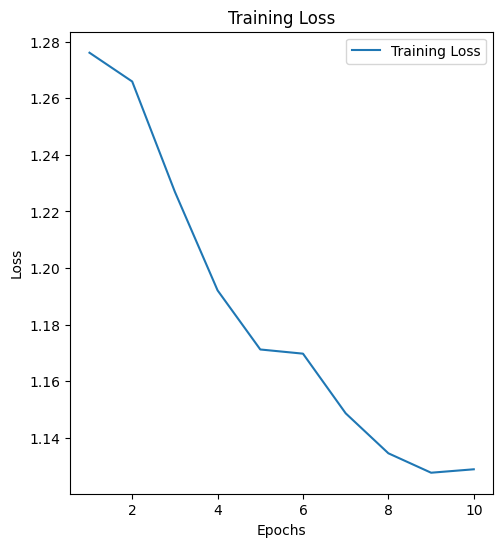

In [19]:
learning_rate = 0.001
epochs =10
model_train(model, train_claims_data, claims_padded, epochs, learning_rate)

Preprocessing the dev set

In [20]:
dev_claim_data_path = "/content/drive/MyDrive/nlp_project/data/dev-claims.json"
dev_claim_data = load_data(dev_claim_data_path)
dev_claims_padded = preprocess_test(dev_claim_data,max_padding_length_train_claims)
print("Create claim id and index relation for dev set...")
dev_claim_id_index = {claim_id:index for index, claim_id in enumerate(dev_claim_data)}

Convert the claim text into tokens...
Converting claim text to indices list
Converting the claims to tensor after truncating
Padding the claims to maximum length
Create claim id and index relation for dev set...


Evaluating the dev set

Epoch [1/10] completed
Epoch [2/10] completed
Epoch [3/10] completed
Epoch [4/10] completed
Epoch [5/10] completed
Epoch [6/10] completed
Epoch [7/10] completed
Epoch [8/10] completed
Epoch [9/10] completed
Epoch [10/10] completed


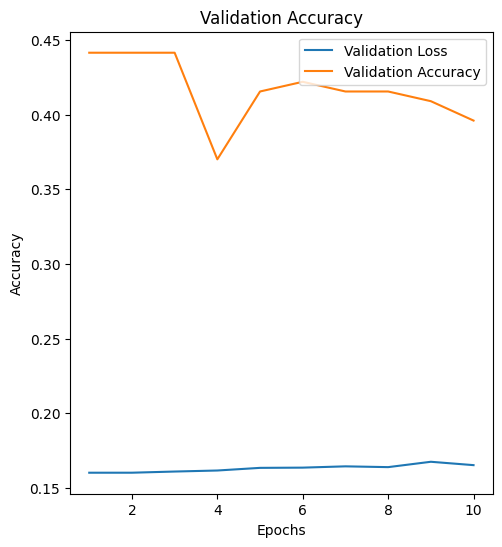

Epoch with maximum accuracy: 0
Evaluation Loss: 0.1602
Evaluation Accuracy:0.4416
Accuracy in all epocs: [0.44155844155844154, 0.44155844155844154, 0.44155844155844154, 0.37012987012987014, 0.4155844155844156, 0.42207792207792205, 0.4155844155844156, 0.4155844155844156, 0.4090909090909091, 0.3961038961038961]
The epoch with maximum accuracy is: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
model_evaluate_dev(model,dev_claim_data,dev_claims_padded,epochs)

Preprocessing the test set

In [22]:
test_claim_data_path = "/content/drive/MyDrive/nlp_project/data/test-claims-unlabelled.json"
test_claim_data = load_data(test_claim_data_path)
test_claims_padded = preprocess_test(test_claim_data,max_padding_length_train_claims)
test_claim_id_index = {claim_id:index for index, claim_id in enumerate(test_claim_data)}

Convert the claim text into tokens...
Converting claim text to indices list
Converting the claims to tensor after truncating
Padding the claims to maximum length


Evaluating the test set

In [23]:
model_evaluate_test(model,test_claim_data,test_claims_padded)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>